# Titanic

**Background:** Recently, one of the greatest
ships built so far hit an iceberg and sank.
Thousands of passengers died due to this
accident

**Goal:** Analyze (using decision trees) if it’s possible to explain who had higher survival chances, based on available data. Provide recommendations for Ubezpieczalnia Jeż how to hedge against incoming claims

## Get data

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

### Load Raw Data

In [ ]:
# Zaczytanie zbioru treningowego train.csv
train_raw_data = pd.read_csv('https://drive.google.com/uc?id=1Ncj2Sa2Lv8a1B98JzyixRyjkcmAzi6c_')

train_raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##  EDA - Train Set

Exploratory Data Analysis on Train Set

In [ ]:
train_raw_data.head()

train_raw_data.info()

train_raw_data.describe()


# count the empty values in the columns
train_raw_data.isnull().sum()
train_raw_data["Age"].isnull().sum()
train_raw_data["Cabin"].isnull().sum()
train_raw_data["Embarked"].isnull().sum()

(train_raw_data["Fare"] == 0).sum() # 15 zeros


# calculate percentage of null values for Age and Cabin
prc_age_null = (train_raw_data["Age"].isnull().sum() / len(train_raw_data)) * 100
prc_age_null # 19.87%

prc_cabin_null = (train_raw_data["Cabin"].isnull().sum() / len(train_raw_data)) * 100
prc_cabin_null # 77.10%

prc_fare_zero = ((train_raw_data["Fare"] == 0).sum() / len(train_raw_data)) * 100
prc_fare_zero # 1.68

# calculate the mean
train_raw_data["Age"].mean() #29.699118

# calculate the mean of non zeros Fare values
(train_raw_data[train_raw_data['Fare'] != 0]['Fare']).mean() # 32.75564988584475


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


32.75564988584475

Based on the Exploratory Data Analysis conducted, I observed the following:

* test set contains of 891 rows
* 20% missing values in the Age column
* 77% missing values in the Cabin column
* 2 missing values in the Embarked column
* 1.68% (15 values) equal 0 in the Fare column


Decisions:

* The missing Age values will be filled with the calculated median, which is 29.
* The zeros Fare values will be filled with the calculated median, which is 32,76.
* The missing Embarked values will be filled with the 'S' value. 'S' stand for Southampton.
* The PassengerId and Cabin columns will be dropped as it does not provide value for further analysis.
* The missing values in the Embarked column will be filled with the name of the port from which the ship departed.

## Transform Data (Train Set)

In [ ]:
# Drop 'PassengerId' and 'Cabin' columns as they are considered to not bring value to the analysis.
df_train_data = train_raw_data.copy().drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])
df_train_data.head()

# Fill Nan with 29 value in Age column
df_train_data['Age'] = df_train_data['Age'].fillna(29.699118)

# Fill Nan with 'S' value in Embarked column
df_train_data['Embarked'] = df_train_data['Embarked'].fillna('S')

# Fill zeros with median=32.7556 value in Fare column
df_train_data.loc[df_train_data['Fare'] == 0, 'Fare'] = 32.7556


df_train_data = pd.get_dummies(df_train_data, columns=['Sex', 'Embarked'], drop_first=True)

### Train Data Set Preview

In [ ]:
print('Prepared Train Data Set:')
df_train_data.head()

Prepared Train Data Set:


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


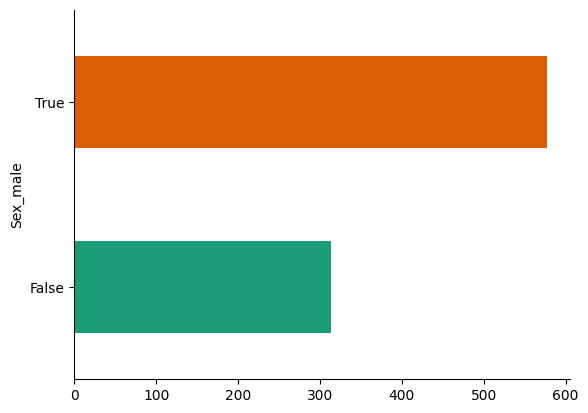

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_train_data.groupby('Sex_male').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

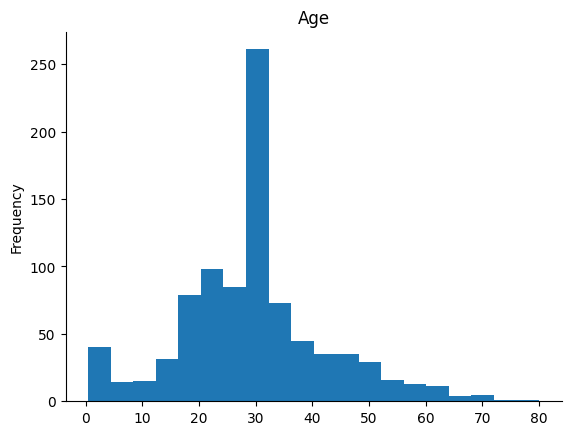

In [ ]:
from matplotlib import pyplot as plt
df_train_data['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Split The Data

We extract a subset of data from the training set, which we will call the validation set


**Training Dataset (Training):**

Purpose: It is used to train the model. The model "trains" on this dataset, learning dependencies and patterns within the data.

**Validation Dataset (Validation):**

Purpose: It is used for tuning the model, that is, adjusting its parameters to achieve optimal performance. It allows us to evaluate how the model handles new data (data it hasn't seen during training) and fine-tune it accordingly.

In [ ]:
# Define the feature set (X) and the target variable (y)
X = df_train_data.drop('Survived', axis=1) # axis=1 defines that we want to remove column, but not row (axis=0)
y = df_train_data['Survived'] # set in y data set target variable labels that indicate whether a passenger survived (1) or not (0)

X # set without target value Survived
y # set of 0/1 values

# Split the data into training and validation sets
# test_size=0.2 means we use 20% of data
# https://www.youtube.com/watch?v=BUkqYGPnLZ8 explainng the function
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train)
print(X_val)
print(y_train)
print(y_val)


     Pclass        Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  \
331       1  45.500000      0      0   28.5000      True       False   
733       2  23.000000      0      0   13.0000      True       False   
382       3  32.000000      0      0    7.9250      True       False   
704       3  26.000000      1      0    7.8542      True       False   
813       3   6.000000      4      2   31.2750     False       False   
..      ...        ...    ...    ...       ...       ...         ...   
106       3  21.000000      0      0    7.6500     False       False   
270       1  29.699118      0      0   31.0000      True       False   
860       3  41.000000      2      0   14.1083      True       False   
435       1  14.000000      1      2  120.0000     False       False   
102       1  21.000000      0      1   77.2875      True       False   

     Embarked_S  
331        True  
733        True  
382        True  
704        True  
813        True  
..          ...  
106      

## Decision Tree Model



### Decision Tree Model Trainig

In [ ]:
# Creating an instance of decision tree

dt = DecisionTreeClassifier(max_depth = 4,
                              random_state = 0,
                              min_samples_leaf = 20,
                              criterion = 'gini')

# Training, aka fitting our model to the data
dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=0)

### Decision Tree Model Validating

In [ ]:
# Prediction
predictions = dt.predict(X_val)


# Ocena modelu
print("Accuracy:", accuracy_score(y_val, predictions)) # 79%
print("Classification Report:\n", classification_report(y_val, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, predictions))


Accuracy: 0.7932960893854749
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.82      0.64      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179

Confusion Matrix:
 [[95 10]
 [27 47]]


### Confusion matrix

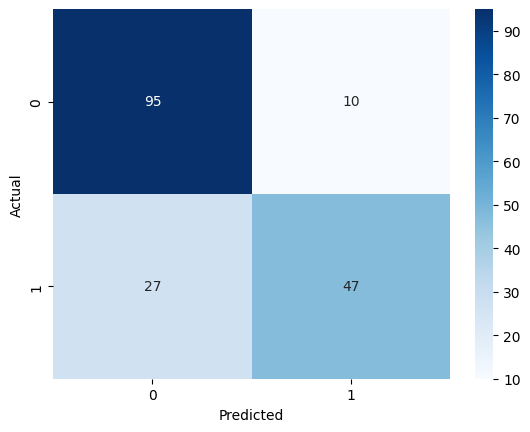

In [ ]:
# Wizualizacja macierzy konfuzji
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Test The Model

### Load Test Data Set

In [ ]:
# Zaczytanie zbioru testowego  test.csv
test_raw_data = pd.read_csv('https://drive.google.com/uc?id=1kY_9DwCwlEzOGj0jmZXeHSTC81Xudupw')


test_raw_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### EDA (Exploratory Data Analysis)

In [ ]:
test_raw_data.head()

test_raw_data.info()

test_raw_data.describe()



# count the empty values in the columns
test_raw_data.isnull().sum()
test_raw_data["Age"].isnull().sum()
test_raw_data["Embarked"].isnull().sum()

(test_raw_data["Fare"] == 0).sum() # 15 zeros


# calculate percentage of null values for Age and Cabin
prc_age_null = (test_raw_data["Age"].isnull().sum() / len(test_raw_data)) * 100
prc_age_null # 20.57%


prc_fare_zero = ((test_raw_data["Fare"] == 0).sum() / len(test_raw_data)) * 100
prc_fare_zero # 0.47

# calculate the mean
test_raw_data["Age"].mean() #30.272590361445783

# calculate the mean of non zeros Fare values
(test_raw_data[test_raw_data['Fare'] != 0]['Fare']).mean() # 35.798885783132526

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


35.798885783132526

### Transform Data

In [ ]:
test_raw_data

# Drop 'PassengerId' and 'Cabin' columns as they are considered to not bring value to the analysis.
df_test_data = test_raw_data.copy().drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])

df_test_data.head()

# Fill Nan with 30 value in Age column
df_test_data['Age'] = df_test_data['Age'].fillna(30)

# Fill Nan with 'S' value in Embarked column
df_test_data['Embarked'] = df_test_data['Embarked'].fillna('S')

# Fill zeros with median=32.7556 value in Fare column
df_test_data.loc[df_test_data['Fare'] == 0, 'Fare'] = 32.7556

# Fill NaN with median=32.7556 value in Fare column
df_test_data['Fare'] = df_test_data['Fare'].fillna(32.7556)



df_test_data

df_test_data = pd.get_dummies(df_test_data, columns=['Sex', 'Embarked'], drop_first=True)


### Predykcja

In [ ]:
# Wykonanie przewidywań dla danych testowych
test_predictions = dt.predict(df_test_data)

In [ ]:
test_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

##### Plot decision tree

In [ ]:
# Creating a plot of our model
plt.subplots(figsize = (15,12))
plot_tree(tree,impurity =True,
          feature_names = tree.feature_names_in_,
          class_names = ['Deceased', 'Survived'],
          filled = True)
plt.show()

## Format results

Przekształcenie Wyników Predykcji do Przyjaznego Formatu

In [ ]:
df_test_data['Predicted_Survival'] = test_predictions

# Map the numeric results back to categorical for better readability
df_test_data['Predicted_Survival'] = df_test_data['Predicted_Survival'].map({0: 'Died', 1: 'Survived'})

# Select relevant columns to display
results_display = df_test_data[['Age', 'Sex_male', 'Fare', 'Predicted_Survival']]

print(results_display.head(100))


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
#prezentacja rekorów wraz z Nazwiskami pasażerów

results_display_with_names = pd.concat([test_raw_data[['PassengerId', 'Name']], results_display], axis=1)
results_display_with_names.head(10)

,PassengerId,Name,Age,Sex_male,Fare,Predicted_Survival,Fare_Category
0,892,"Kelly, Mr. James",34.5,True,7.8292,Died,Low
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,False,7.0000,Died,Low
2,894,"Myles, Mr. Thomas Francis",62.0,True,9.6875,Died,Low
3,895,"Wirz, Mr. Albert",27.0,True,8.6625,Died,Low
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,False,12.2875,Died,Low
5,897,"Svensson, Mr. Johan Cervin",14.0,True,9.2250,Died,Low
6,898,"Connolly, Miss. Kate",30.0,False,7.6292,Survived,Low
7,899,"Caldwell, Mr. Albert Francis",26.0,True,29.0000,Died,Medium
8,900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.0,False,7.2292,Survived,Low
9,901,"Davies, Mr. John Samuel",21.0,True,24.1500,Died,Medium


### Prepare Kaggle submission

In [ ]:
# Prepare Submission File Format for Kaggle
kagle_submission = results_display_with_names[['PassengerId', 'Predicted_Survival']]
kagle_submission = kagle_submission.rename(columns={'Predicted_Survival': 'Survived'})

# Replace 'Survived' and 'Died' with 1 and 0 respectively
kagle_submission['Survived'] = kagle_submission['Survived'].replace({'Survived': 1, 'Died': 0})

# Display the updated DataFrame
print(kagle_submission.head())

kagle_submission.to_csv('kagle_submission.csv', index=False)

from google.colab import files
files.download('kagle_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualization of the Overall Survival Prediction

Chart to show the count of predicted survivors vs. non-survivors
---



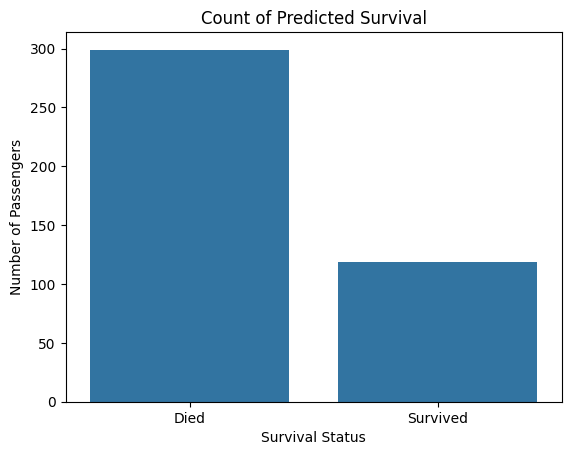

In [ ]:
# Count plot of predicted survival
sns.countplot(x='Predicted_Survival', data=results_display)
plt.title('Count of Predicted Survival')
plt.xlabel('Survival Status')
plt.ylabel('Number of Passengers')
plt.show()

Detailed Analysis of Survival by Gender
A bar chart showing the survival count broken down by gender can provide insights into which group had higher survival chances.

<ipython-input-20-6adae1ade9d5>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Female', 'Male'])


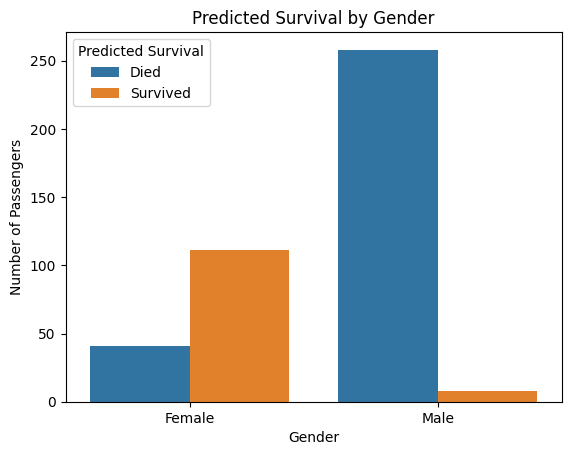

In [ ]:
# Tworzenie wykresu
ax = sns.countplot(x='Sex_male', hue='Predicted_Survival', data=results_display)
plt.title('Predicted Survival by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Passengers')
plt.legend(title='Predicted Survival', labels=['Died', 'Survived'])

# Ustawienie nowych etykiet osi X
ax.set_xticklabels(['Female', 'Male'])

plt.show()

Survival Based on Fare Class
Higher fares might correlate with higher survival rates, possibly due to cabin location.

<ipython-input-21-743d2b36c91a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_display['Fare_Category'] = pd.cut(results_display['Fare'], bins=[0, 20, 100, 600], labels=['Low', 'Medium', 'High'])


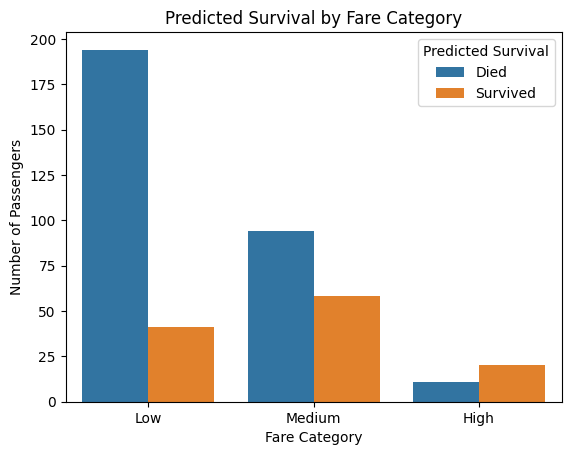

In [ ]:
# Assuming 'Fare' can be categorized into low, medium, and high classes for better insights
results_display['Fare_Category'] = pd.cut(results_display['Fare'], bins=[0, 20, 100, 600], labels=['Low', 'Medium', 'High'])

sns.countplot(x='Fare_Category', hue='Predicted_Survival', data=results_display)
plt.title('Predicted Survival by Fare Category')
plt.xlabel('Fare Category')
plt.ylabel('Number of Passengers')
plt.legend(title='Predicted Survival', labels=['Died', 'Survived'])
plt.show()

Age Distribution of Survival


Visualizing how age affects the survival prediction can be insightful.

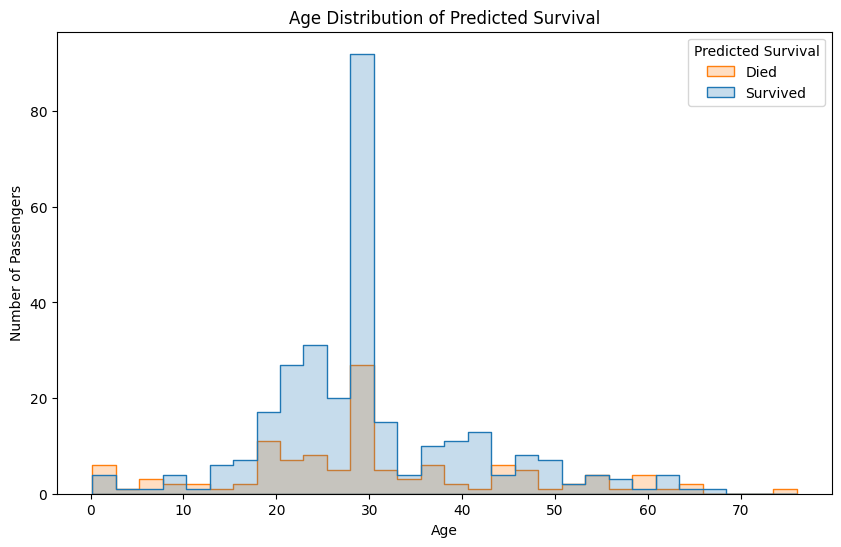

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=results_display, x='Age', hue='Predicted_Survival', element='step', bins=30)
plt.title('Age Distribution of Predicted Survival')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.legend(title='Predicted Survival', labels=['Died', 'Survived'])
plt.show()

# Probabilities

In [ ]:
df_test_data_for_prob = df_test_data.drop('Predicted_Survival', axis=1)

# Predict probabilities for the test data
probabilities = dt.predict_proba(df_test_data_for_prob)

# probabilities is a NumPy array where each row corresponds to a case,
# and columns correspond to classes; [P(died), P(survived)]

# Capture the probabilities of death
death_probabilities = probabilities[:, 0]  # We take the first column, which corresponds to death


Analyzing the Probabilities
You can now analyze these probabilities, for example, by calculating the average probability of death:

In [ ]:
# Calculate the average probability of death
average_death_probability = np.mean(death_probabilities)
print(f"Average probability of death: {average_death_probability:.2f}")


Average probability of death: 0.60


Presenting the Results

To better visualize these probabilities, you can use a visualization, such as a histogram:


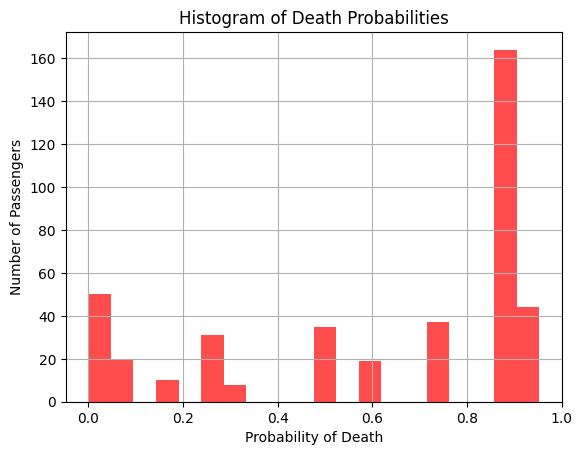

In [ ]:
# Create a histogram of death probabilities
plt.hist(death_probabilities, bins=20, color='red', alpha=0.7)
plt.title('Histogram of Death Probabilities')
plt.xlabel('Probability of Death')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()
